In [1]:
import pandas as pd

In [2]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_product_category_name = pd.read_csv('product_category_name_translation.csv')

df_train = df_orders.merge(df_order_items, on='order_id', how='left')
df_train = df_train.merge(df_order_payments, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_order_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')
df_train = df_train.merge(df_product_category_name, on='product_category_name', how='inner')

# Current

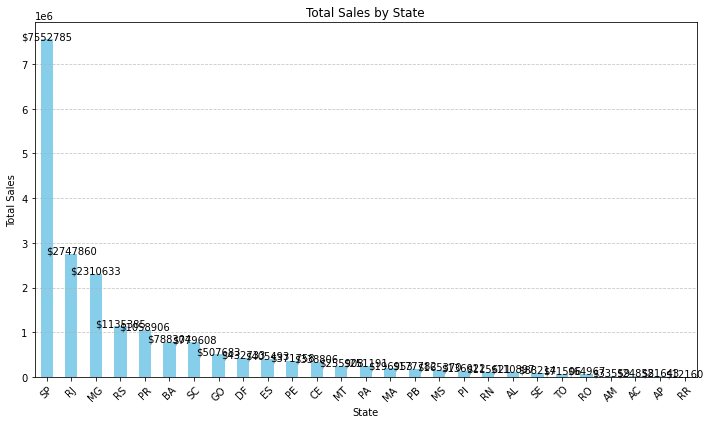

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train is your DataFrame
# Let's group the data by 'customer_state' and calculate the sum of 'payment_value' for each state
state_sales = df_train.groupby('customer_state')['payment_value'].sum().sort_values(ascending=False)

# Plotting the graph
plt.figure(figsize=(10, 6))
state_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

# Adding values above the bars
for i, value in enumerate(state_sales):
    plt.text(i, value + 1000, f'${value:.0f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


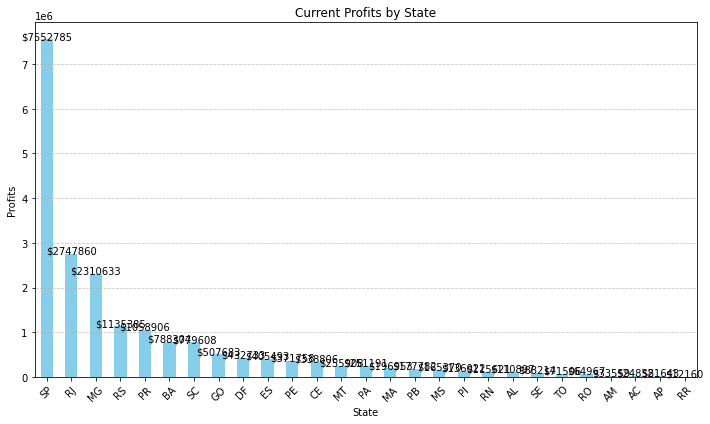

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train is your DataFrame
# Let's group the data by 'customer_state' and calculate the sum of 'payment_value' for each state
state_profits = df_train.groupby('customer_state')['payment_value'].sum().sort_values(ascending=False)

# Plotting the graph
plt.figure(figsize=(10, 6))
state_profits.plot(kind='bar', color='skyblue')
plt.title('Current Profits by State')
plt.xlabel('State')
plt.ylabel('Profits')
plt.xticks(rotation=45)

# Adding values above the bars
for i, value in enumerate(state_profits):
    plt.text(i, value + 1000, f'${value:.0f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Predictions

Train R^2 Score: 0.9996627730593162
Test R^2 Score: 0.7851262313085582


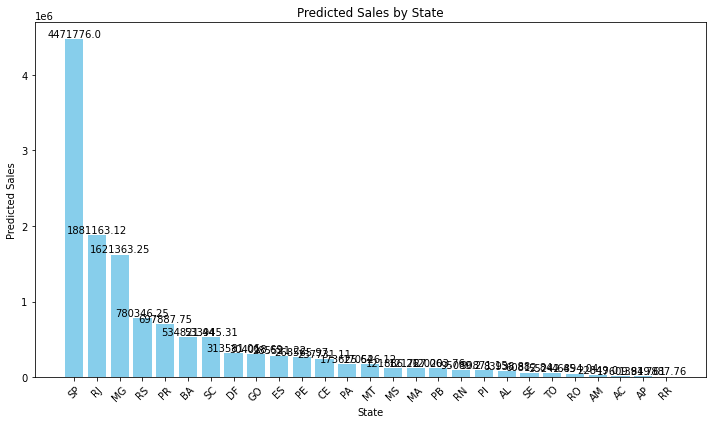

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load the data
# Assuming df_train contains the provided dataframe

# Calculate profit and revenue
df_train['profit'] = df_train['price'] - df_train['freight_value']
df_train['revenue'] = df_train['price'] + df_train['freight_value']

# Aggregate sales data by state and product category
sales_data = df_train.groupby(['customer_state', 'product_category_name_english']).agg({
    'price': 'sum',
    'profit': 'sum',
    'revenue': 'sum'
}).reset_index()

# Prepare features and target variable
X = sales_data.drop(['price'], axis=1)  # Features: state, product category, profit, revenue
y = sales_data['price']  # Target variable: total sales

# Convert categorical variables into dummy variables
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
train_score = r2_score(y_train, model.predict(X_train))
test_score = r2_score(y_test, model.predict(X_test))
print("Train R^2 Score:", train_score)
print("Test R^2 Score:", test_score)

# Predict sales for each state
predictions = model.predict(X)

# Create a dataframe with predicted sales
predicted_sales = pd.DataFrame({
    'customer_state': sales_data['customer_state'],
    'product_category_name_english': sales_data['product_category_name_english'],
    'predicted_sales': predictions
})

# Group by state and sum the predicted sales
predicted_sales_by_state = predicted_sales.groupby('customer_state')['predicted_sales'].sum().reset_index()

# Sort states by predicted sales
predicted_sales_by_state = predicted_sales_by_state.sort_values(by='predicted_sales', ascending=False)

# Visualize the results
plt.figure(figsize=(10, 6))
bars = plt.bar(predicted_sales_by_state['customer_state'], predicted_sales_by_state['predicted_sales'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Predicted Sales')
plt.title('Predicted Sales by State')
plt.xticks(rotation=45)
plt.tight_layout()

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()


In [6]:
# Define a function to format the predicted sales as money values
def format_money(value):
    return "${:,.2f}".format(value)

# Group by state and product category, sum the predicted sales
grouped_sales = predicted_sales.groupby(['customer_state', 'product_category_name_english'])['predicted_sales'].sum().reset_index()

# Get top 3 products for each state
top3_products = grouped_sales.groupby('customer_state').apply(lambda x: x.nlargest(3, 'predicted_sales')).reset_index(drop=True)

# Format predicted sales as money values
top3_products['predicted_sales'] = top3_products['predicted_sales'].map(format_money)

top3_products


,customer_state,product_category_name_english,predicted_sales
0,AC,watches_gifts,"$2,425.13"
1,AC,sports_leisure,"$1,681.19"
2,AC,health_beauty,"$1,392.73"
3,AL,health_beauty,"$13,690.24"
4,AL,watches_gifts,"$12,563.82"
...,...,...,...
76,SP,housewares,"$289,907.31"
77,SP,bed_bath_table,"$235,220.78"
78,TO,home_appliances_2,"$6,561.53"
79,TO,watches_gifts,"$5,538.14"


Train R^2 Score: 0.7326423692717885
Test R^2 Score: 0.14742625002061915


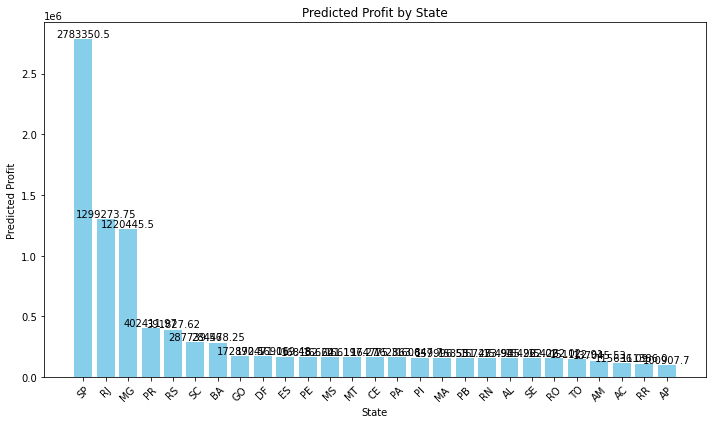

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load the data
# Assuming df_train contains the provided dataframe

# Calculate profit and revenue
df_train['profit'] = df_train['price'] - df_train['freight_value']
df_train['revenue'] = df_train['price'] + df_train['freight_value']

# Aggregate sales data by state and product category
sales_data = df_train.groupby(['customer_state', 'product_category_name_english']).agg({
    'profit': 'sum'  # Change to profit instead of price
}).reset_index()

# Prepare features and target variable
X = sales_data.drop(['profit'], axis=1)  # Features: state, product category
y = sales_data['profit']  # Target variable: total profit

# Convert categorical variables into dummy variables
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
train_score = r2_score(y_train, model.predict(X_train))
test_score = r2_score(y_test, model.predict(X_test))
print("Train R^2 Score:", train_score)
print("Test R^2 Score:", test_score)

# Predict profit for each state
predictions = model.predict(X)

# Create a dataframe with predicted profit
predicted_profit = pd.DataFrame({
    'customer_state': sales_data['customer_state'],
    'product_category_name_english': sales_data['product_category_name_english'],
    'predicted_profit': predictions
})

# Group by state and sum the predicted profit
predicted_profit_by_state = predicted_profit.groupby('customer_state')['predicted_profit'].sum().reset_index()

# Sort states by predicted profit
predicted_profit_by_state = predicted_profit_by_state.sort_values(by='predicted_profit', ascending=False)

# Visualize the results
plt.figure(figsize=(10, 6))
bars = plt.bar(predicted_profit_by_state['customer_state'], predicted_profit_by_state['predicted_profit'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Predicted Profit')
plt.title('Predicted Profit by State')
plt.xticks(rotation=45)
plt.tight_layout()

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()


In [8]:
# Group by state and product category and sum the predicted profit
predicted_profit_by_state_category = predicted_profit.groupby(['customer_state', 'product_category_name_english'])['predicted_profit'].sum().reset_index()

# Sort predictions within each state and select the top 3 product categories
top_3_categories_by_state = predicted_profit_by_state_category.groupby('customer_state').apply(lambda x: x.nlargest(3, 'predicted_profit')).reset_index(drop=True)

# Format predicted_profit column as money
top_3_categories_by_state['predicted_profit'] = top_3_categories_by_state['predicted_profit'].map('${:,.2f}'.format)

top_3_categories_by_state

,customer_state,product_category_name_english,predicted_profit
0,AC,health_beauty,"$18,008.32"
1,AC,watches_gifts,"$13,829.92"
2,AC,computers_accessories,"$12,007.07"
3,AL,health_beauty,"$19,656.32"
4,AL,watches_gifts,"$15,615.33"
...,...,...,...
76,SP,housewares,"$160,417.27"
77,SP,cool_stuff,"$136,817.50"
78,TO,health_beauty,"$19,656.32"
79,TO,watches_gifts,"$15,615.33"
